# Women in Data Science 2022. TIM 

The WiDS Datathon 2022 focuses on a prediction task involving roughly 100k observations of building energy usage records collected over 7 years and a number of states within the United States. The dataset consists of building characteristics (e.g. floor area, facility type etc), weather data for the location of the building (e.g. annual average temperature, annual total precipitation etc) as well as the energy usage for the building and the given year, measured as Site Energy Usage Intensity (Site EUI). Each row in the data corresponds to the a single building observed in a given year. Your task is to predict the Site EUI for each row, given the characteristics of the building and the weather data for the location of the building.

## **Data Dictionary**
Covariates
id: building id

Year_Factor: anonymized year in which the weather and energy usage factors were observed

State_Factor: anonymized state in which the building is located

building_class: building classification

facility_type: building usage type

floor_area: floor area (in square feet) of the building

year_built: year in which the building was constructed

energy_star_rating: the energy star rating of the building

ELEVATION: elevation of the building location

january_min_temp: minimum temperature in January (in Fahrenheit) at the location of the building

january_avg_temp: average temperature in January (in Fahrenheit) at the location of the building

january_max_temp: maximum temperature in January (in Fahrenheit) at the location of the building

cooling_degree_days: cooling degree day for a given day is the number of degrees where the daily average temperature exceeds 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.

heating_degree_days: heating degree day for a given day is the number of degrees where the daily average temperature falls under 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.

precipitation_inches: annual precipitation in inches at the location of the building

snowfall_inches: annual snowfall in inches at the location of the building

snowdepth_inches: annual snow depth in inches at the location of the building

avg_temp: average temperature over a year at the location of the building

days_below_30F: total number of days below 30 degrees Fahrenheit at the location of the building

days_below_20F: total number of days below 20 degrees Fahrenheit at the location of the building

days_below_10F: total number of days below 10 degrees Fahrenheit at the location of the building

days_below_0F: total number of days below 0 degrees Fahrenheit at the location of the building

days_above_80F: total number of days above 80 degrees Fahrenheit at the location of the building

days_above_90F: total number of days above 90 degrees Fahrenheit at the location of the building

days_above_100F: total number of days above 100 degrees Fahrenheit at the location of the building

days_above_110F: total number of days above 110 degrees Fahrenheit at the location of the building

direction_max_wind_speed: wind direction for maximum wind speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).

direction_peak_wind_speed: wind direction for peak wind gust speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).

max_wind_speed: maximum wind speed at the location of the building

days_with_fog: number of days with fog at the location of the building

## **Target**
site_eui: Site Energy Usage Intensity is the amount of heat and electricity consumed by a building as reflected in utility bills


In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn import svm
from sklearn.ensemble import ExtraTreesRegressor
from scipy import stats

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

sns.set()

import random



In [2]:
#Load data
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [3]:
print(train.shape,test.shape)

(75757, 64) (9705, 63)


In [4]:
#Combining train and test dataset for preprocessing
all_df=pd.concat([train,test], ignore_index=True,sort=False)

In [5]:
#Dropping target
# all_df.drop('site_eui',axis=1,inplace=True)

## Target

site_eui: Site Energy Usage Intensity is the amount of heat and electricity consumed by a building as reflected in utility bills.


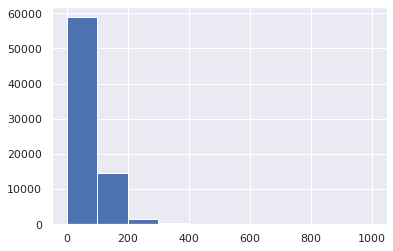

In [6]:
train["site_eui"].hist()

In [7]:
train["site_eui"]

0        248.682615
1         26.500150
2         24.693619
3         48.406926
4          3.899395
            ...    
75752    132.918411
75753     39.483672
75754     48.404398
75755    592.022750
75756     29.154684
Name: site_eui, Length: 75757, dtype: float64

## Missing values.


In [8]:
missings_df={}
for key in all_df.columns:
    if all_df[key].isnull().sum() > 0:
        missings_df[key]=(all_df[key].isnull().sum()  /  len(all_df[key]) ) * 100

#Create missing values dataframe
missings_df=pd.DataFrame(missings_df,index=['MissingValues']).T.sort_values(by='MissingValues',ascending=False)

Text(0.5, 1.0, 'The percentage of missing values per column')

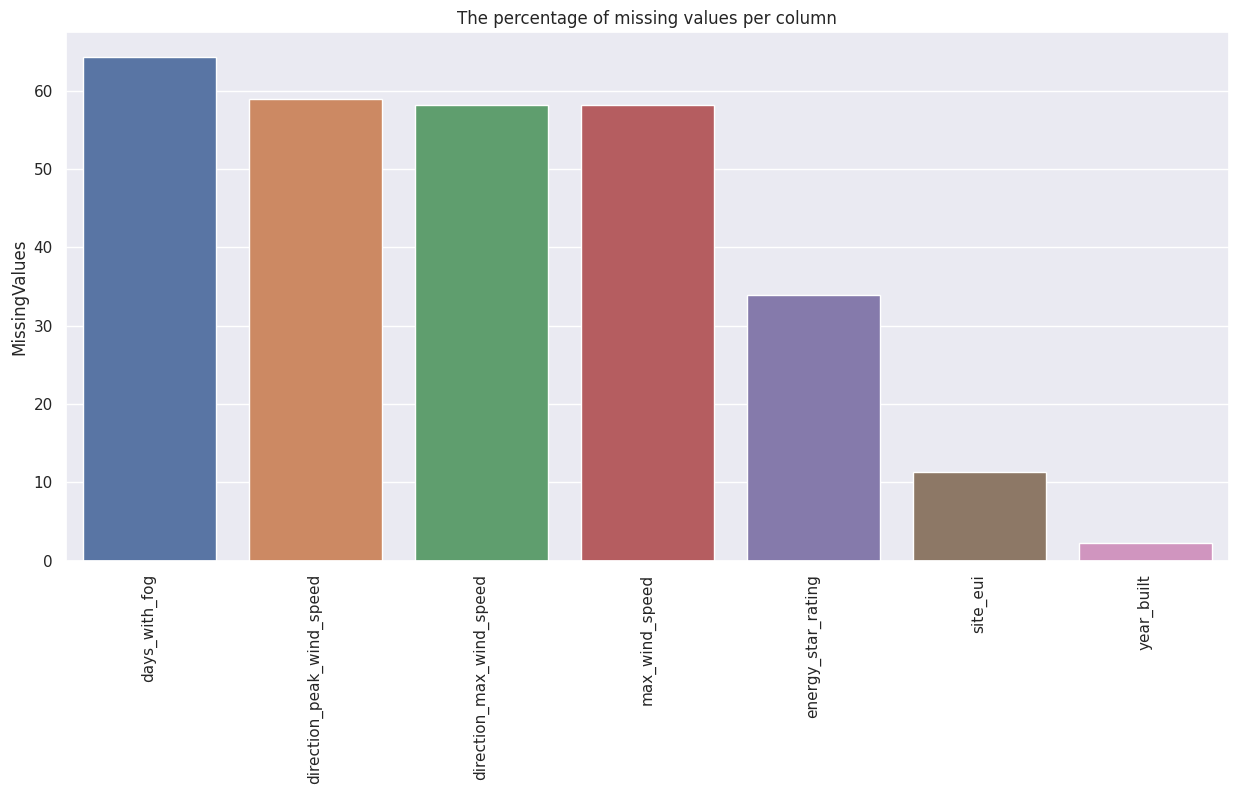

In [9]:
#Plotting the percentage of missing values per column
plt.figure(figsize=(15,7),dpi=100)
plt.xticks(rotation=90)
sns.barplot(y=missings_df.MissingValues,x=missings_df.index, orient='v').set_title('The percentage of missing values per column')

## Categorical features.

In [10]:
#Sort transposed describe() by count
all_df.describe(include='object').T.sort_values(by=['count']).head(10)


,count,unique,top,freq
State_Factor,85462,7,State_6,50840
building_class,85462,2,Residential,47656
facility_type,85462,60,Multifamily_Uncategorized,41654


In [11]:
# check duplicates
all_df.duplicated().sum()

0

In [12]:
# drop duplicates.
all_df.drop_duplicates(inplace=True)

In [13]:
# check duplicates
all_df.duplicated().sum()

0

## 2. Dealing with missing values.

In [14]:
# Check missing values.
precent_missing = all_df.isnull().sum()*100/len(all_df)
missing_value_df = pd.DataFrame({'column_name': all_df.columns,
                                'percent_missing': precent_missing}).sort_values('percent_missing', ascending=False)
missing_value_df

,column_name,percent_missing
days_with_fog,days_with_fog,64.254288
direction_peak_wind_speed,direction_peak_wind_speed,58.957197
max_wind_speed,max_wind_speed,58.104187
direction_max_wind_speed,direction_max_wind_speed,58.104187
energy_star_rating,energy_star_rating,33.889916
...,...,...
july_avg_temp,july_avg_temp,0.000000
july_max_temp,july_max_temp,0.000000
august_min_temp,august_min_temp,0.000000
august_avg_temp,august_avg_temp,0.000000


In [15]:
# Deletion of features with more than 40% missing values.

cols_to_drop = missing_value_df[missing_value_df['percent_missing'] > 40].index.values
print("Cols:", cols_to_drop)

print("Columnas pre drop:", len(all_df.columns))

all_df.drop(columns=cols_to_drop, inplace=True)

print("Columnas post drop:", len(all_df.columns))

Cols: ['days_with_fog' 'direction_peak_wind_speed' 'max_wind_speed'
 'direction_max_wind_speed']
Columnas pre drop: 64
Columnas post drop: 60


In [16]:
# Delete Column  'Id'.
all_df.drop(['id'],inplace=True,axis=1)

In [17]:
# Imputation of missing values.
all_df['energy_star_rating'] = all_df['energy_star_rating'].fillna(random.randint(1,100))


In [18]:
all_df['year_built'] = all_df['year_built'].fillna(random.randint(all_df.year_built.min(),all_df.year_built.max()))


In [19]:
all_df.loc[all_df['year_built'] != 0] 


,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,248.682615
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,26.500150
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,24.693619
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,48.406926
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,3.899395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85457,7,State_11,Residential,5plus_Unit_Building,305925.0,2013.0,99.0,812.0,21,38.66129,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,NaN
85458,7,State_11,Residential,5plus_Unit_Building,34909.0,1910.0,94.0,26.5,21,38.66129,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,NaN
85459,7,State_11,Residential,5plus_Unit_Building,42393.0,2014.0,94.0,812.0,21,38.66129,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,NaN
85460,7,State_11,Residential,5plus_Unit_Building,25368.0,1992.0,79.0,812.0,21,38.66129,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28

In [20]:
#df_train['direction_max_wind_speed'] = df_train['direction_max_wind_speed'].fillna(random.randint(df_train.direction_max_wind_speed.min(),df_train.direction_max_wind_speed.max()))


In [21]:
#df_train['direction_peak_wind_speed'] = df_train['direction_peak_wind_speed'].fillna(random.randint(df_train.direction_peak_wind_speed.min(),df_train.direction_peak_wind_speed.max()))


In [22]:
#df_train['days_with_fog'] = df_train['days_with_fog'].fillna(random.randint(df_train.days_with_fog.min(),df_train.days_with_fog.max()))


In [23]:
#aux=df_train.max_wind_speed.unique().tolist()


In [24]:
#aux = [x for x in aux if math.isnan(x) == False]


In [25]:
#df_train['max_wind_speed'] = df_train['max_wind_speed'].fillna(random.choice(aux))


In [26]:
all_df['site_eui']

0        248.682615
1         26.500150
2         24.693619
3         48.406926
4          3.899395
            ...    
85457           NaN
85458           NaN
85459           NaN
85460           NaN
85461           NaN
Name: site_eui, Length: 85462, dtype: float64

In [27]:
all_df['site_eui'] = all_df['site_eui'].fillna(all_df["site_eui"].mean())


In [28]:

null_count = all_df.isnull().sum()
null_percentage = round((all_df.isnull().sum()/all_df.shape[0])*100, 2)
null_df = pd.DataFrame({'column_name' : all_df.columns,'null_count' : null_count,'null_percentage': null_percentage})
null_df.reset_index(drop = True, inplace = True)
null_df.sort_values(by = 'null_percentage', ascending = False)

,column_name,null_count,null_percentage
0,Year_Factor,0,0.0
44,cooling_degree_days,0,0.0
32,september_min_temp,0,0.0
33,september_avg_temp,0,0.0
34,september_max_temp,0,0.0
35,october_min_temp,0,0.0
36,october_avg_temp,0,0.0
37,october_max_temp,0,0.0
38,november_min_temp,0,0.0
39,november_avg_temp,0,0.0


### Adding new features.?????

# 4. Encoding categorical features using Pandas.

In [29]:
# Apply LabelEncoder for categorical features.

number = LabelEncoder()

all_df['facility_type'] = number.fit_transform(all_df['facility_type'].astype(str))
all_df['State_Factor'] = number.fit_transform(all_df['State_Factor'].astype(str))
all_df['building_class'] = number.fit_transform(all_df['building_class'].astype(str))

# 4.2. Random Forest

In [30]:
from sklearn.ensemble import RandomForestRegressor


In [33]:
X = all_df.drop(["site_eui"],axis=1)
y= all_df["site_eui"]

In [34]:
# Train the mode

forest = RandomForestRegressor(n_estimators = 100)

forest.fit(X,y)

RandomForestRegressor()

In [35]:
importances = forest.feature_importances_
#
# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]

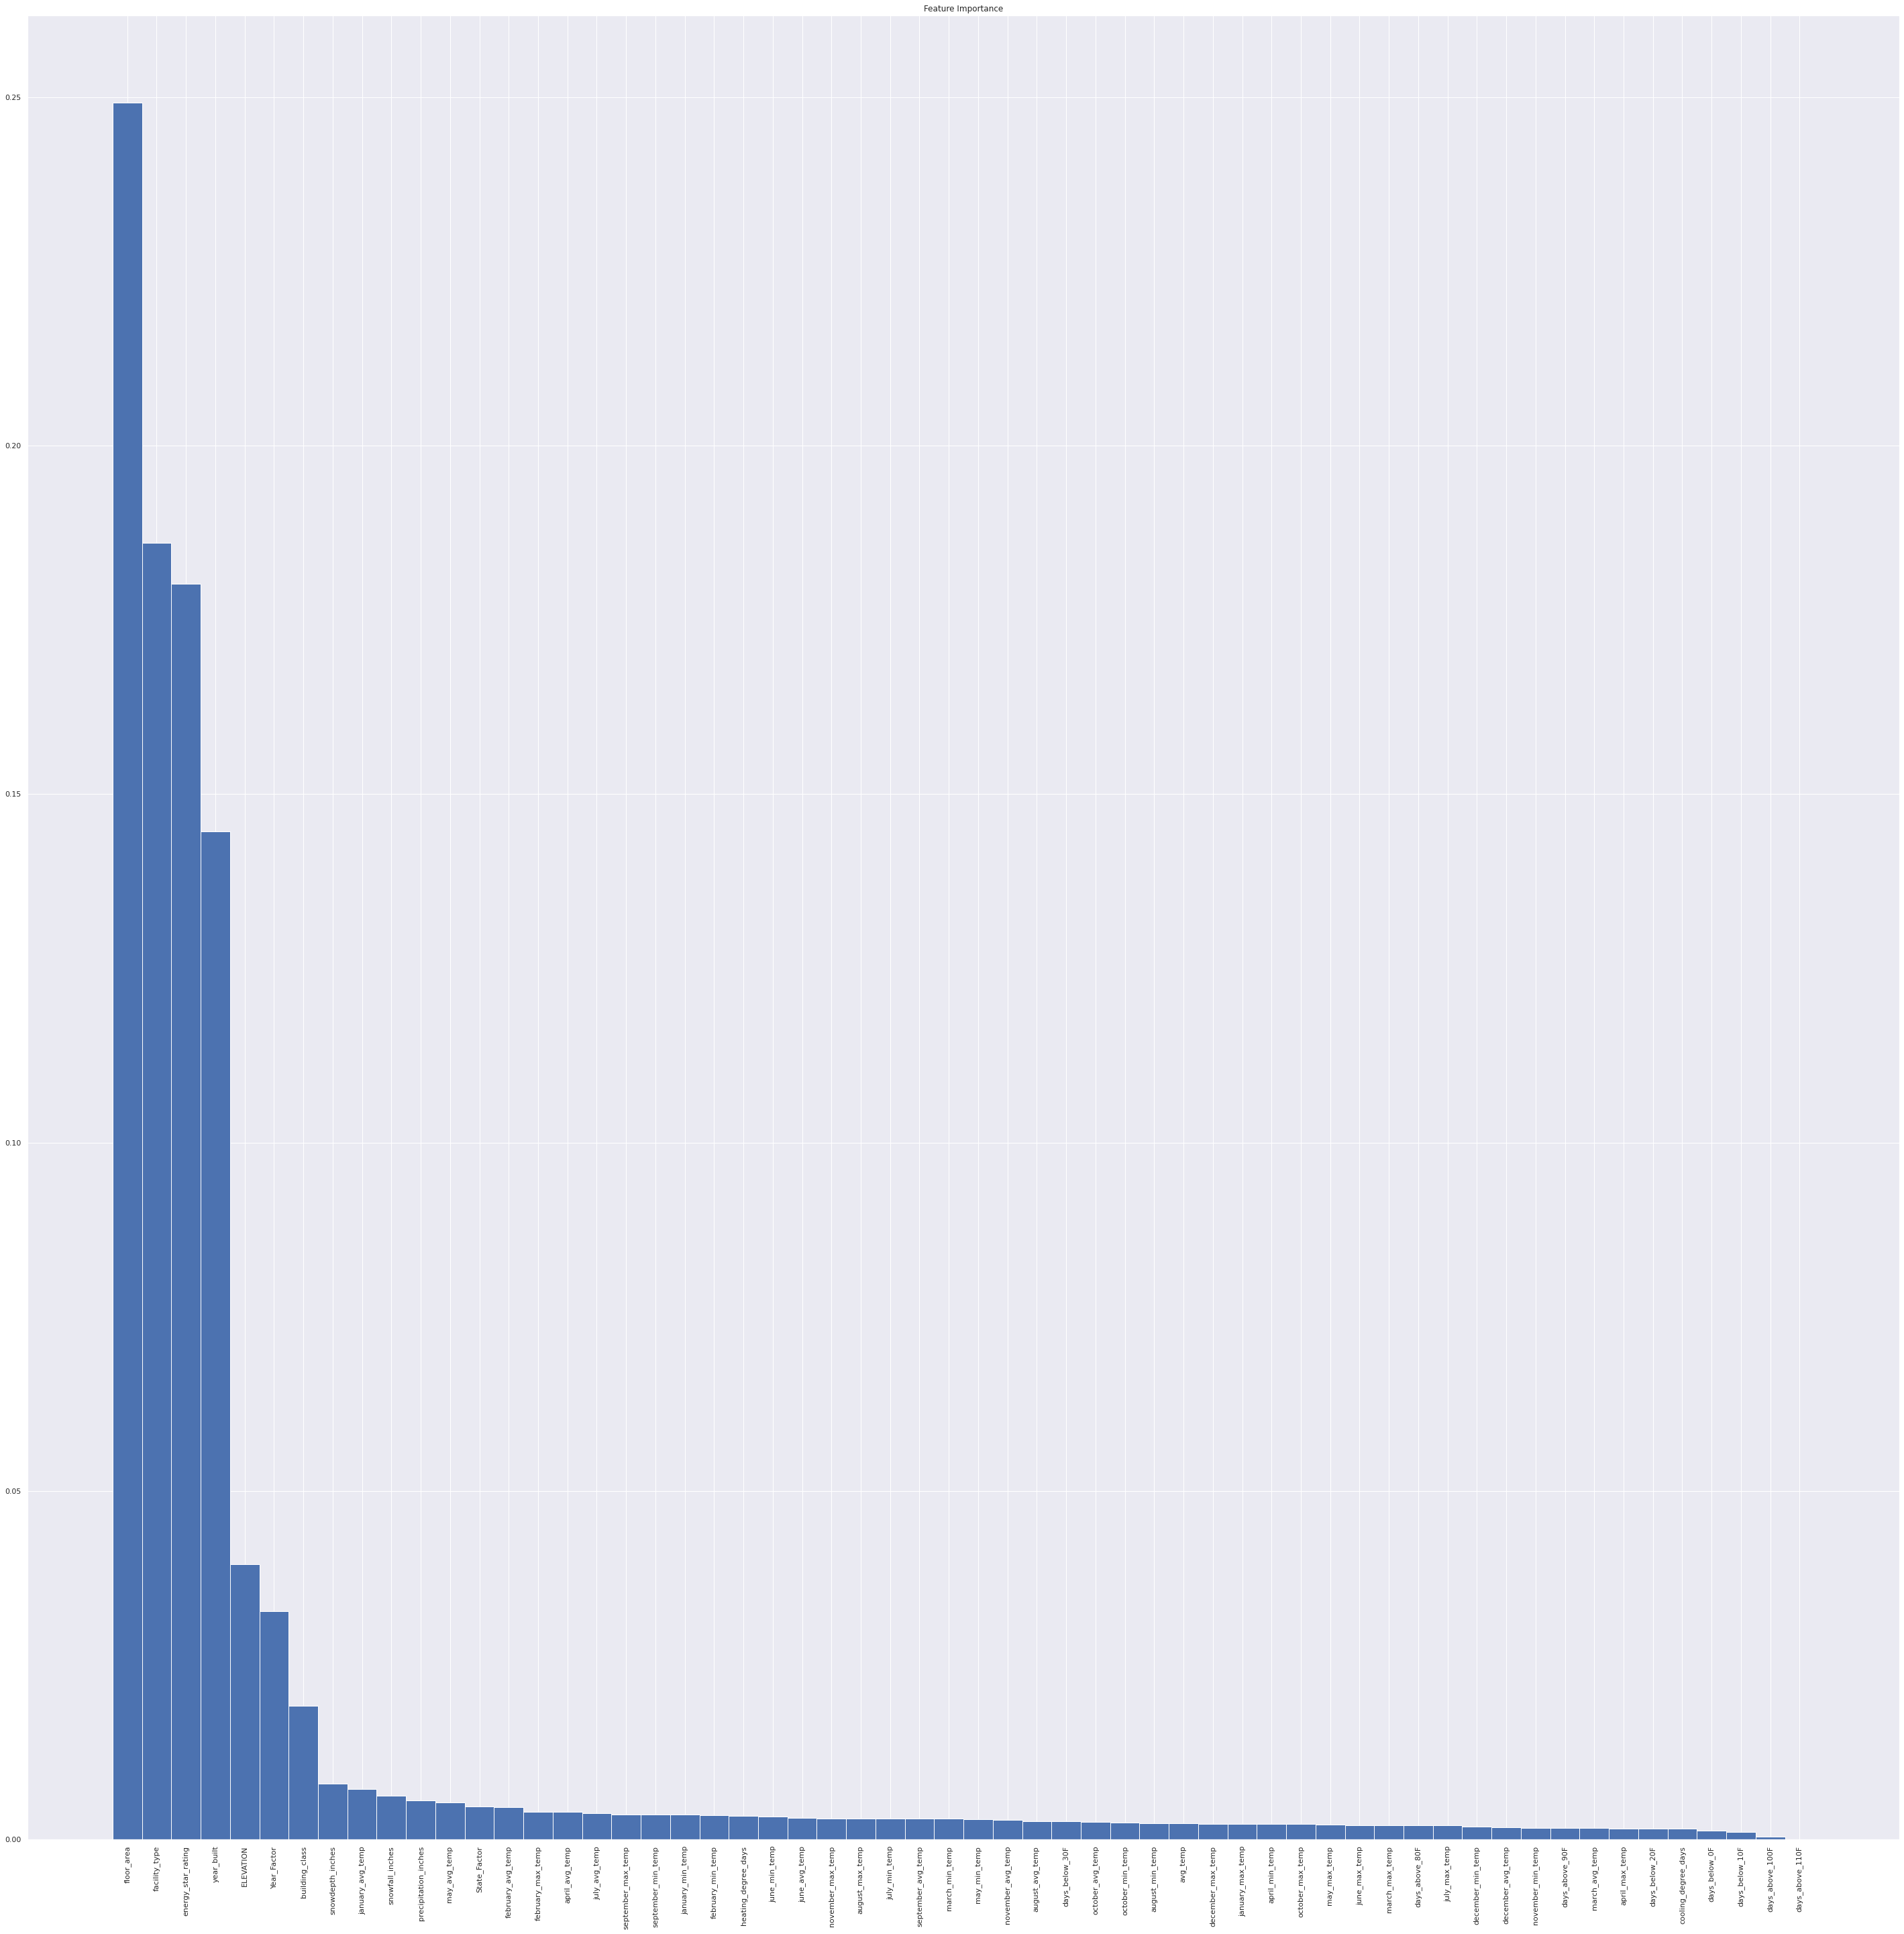

<Figure size 7200x7200 with 0 Axes>

In [44]:
plt.title('Feature Importance')
plt.bar(range(X.shape[1]), importances[sorted_indices], align='center',width=1)
plt.xticks(range(X.shape[1]), X.columns[sorted_indices], rotation=90)

plt.figure(figsize=(100,100))
#plt.rcParams["figure.figsize"] = (50,50)
plt.rcParams.update({'font.size': 30})

plt.tight_layout()
plt.show()

#5.Splitting data to train/test.

Before dealing with outliers I have to split the combined dataframes to train and test, because we want to remove outliers only from train dataset¶

In [56]:
all_df1=all_df[['floor_area','facility_type','energy_star_rating','year_built','site_eui']]

In [57]:
#Split data after encoding
train_df=all_df1[:75000].copy()

test_df=all_df1[75000:].copy()

In [58]:
train_df

,floor_area,facility_type,energy_star_rating,year_built,site_eui
0,61242.0,13,11.0,1942.0,248.682615
1,274000.0,55,45.0,1955.0,26.500150
2,280025.0,48,97.0,1951.0,24.693619
3,55325.0,6,46.0,1980.0,48.406926
4,66000.0,56,100.0,1985.0,3.899395
...,...,...,...,...,...
74995,130600.0,1,92.0,2007.0,25.650406
74996,22018.0,0,92.0,1926.0,24.172155
74997,28160.0,0,95.0,1965.0,23.718628
74998,22405.0,1,27.0,1975.0,26.384463


# 6. Discovering Outliers using Z-score


In [59]:
#columns for z-score calculation
numeric_columns=train_df.columns 
#Calculating z-score using stats library
z = np.abs(stats.zscore( train_df[numeric_columns]))

#train_df.select_dtypes(include=[np.number]).columns.values  // Returns only numeric columns


In [60]:
#Removing outliers on temporary dataframe
train_df_z=train_df.copy()[(z < 10).all(axis=1)]

print('Rows,columns Before removing outliers : ', train_df.shape )
print('Rows,columns After removing outliers : ', train_df_z.shape )

Rows,columns Before removing outliers :  (75000, 5)
Rows,columns After removing outliers :  (74824, 5)


# 7 . Time to modelling.

In [61]:
train_df_z.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 74824 entries, 0 to 74999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   floor_area          74824 non-null  float64
 1   facility_type       74824 non-null  int64  
 2   energy_star_rating  74824 non-null  float64
 3   year_built          74824 non-null  float64
 4   site_eui            74824 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 3.4 MB


In [62]:
# features to drop.
to_drop=['site_eui','Year_Factor',
         'State_Factor',
         'building_class',
         'facility_type',
         'floor_area',
         'year_built',
         'energy_star_rating',
         'ELEVATION',
         'january_min_temp',
         'january_avg_temp',
         'january_max_temp',
         'february_min_temp',
         'february_avg_temp',
         'february_max_temp',
         'march_min_temp',
         'march_avg_temp',
         'march_max_temp',
         'april_min_temp',
         'april_avg_temp',
         'april_max_temp',
         'may_min_temp',
         'may_avg_temp',
         'may_max_temp',
         'june_avg_temp',        
         'july_avg_temp', 
         'august_avg_temp',
         'precipitation_inches',
         'snowdepth_inches',
         'avg_temp',
         'days_below_30F',
         'days_below_20F'
         ]


In [63]:
#will be dropped from test data
to_drop_t=to_drop[1:]

In [64]:
# Define dependent and independent variables

#Independent variables 
X=train_df_z.drop(['site_eui'],axis=1)
#Dependent variable
y=train_df_z['site_eui']

#scaling features
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

#spliting train dataset to train and validation
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

In [65]:
#Define score functions


# evaluate a given model by making predictions on X_valid
def get_v_score(model):
    valid_predictions=model.predict(X_valid)
    score=np.sqrt(mean_squared_error(y_valid, valid_predictions))
    return score

# evaluate a given model using cross-validation
def get_cv_score(model, X, y):
    #cv = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1))
    return np.mean(scores)

In [66]:
#Define models

# Models name
models_name=['RandomForestRegressor',
             'GradientBoostingRegressor',
             'XGBRegressor',
             'svm.SVR',
             'ExtraTreesRegressor',
             'Lasso']
# Models
models=[RandomForestRegressor(),
        GradientBoostingRegressor(),
        XGBRegressor(),
        svm.SVR(),
        ExtraTreesRegressor(),
        Lasso(alpha=0.0005,tol=0.001)]

In [67]:
#Get score for each model

#Fit and get scores for each model
scores_list=[]
for model in models:
    model.fit(X_train,y_train)
    scores_list.append(get_v_score(model))

[15:25:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [68]:
#Convert list to dataframe
data={'Model':models_name,'RMSE': scores_list}
scores_df=pd.DataFrame(data)
#Sort by valid RMSLE
scores_df.sort_values(by='RMSE').round(5).style.set_properties(**{'background-color': 'black','color': 'white'})

,Model,RMSE
0,RandomForestRegressor,31.155420
4,ExtraTreesRegressor,31.987600
1,GradientBoostingRegressor,39.803050
2,XGBRegressor,39.887300
3,svm.SVR,46.477970
5,Lasso,48.403230


In [69]:
# Hyperparameters.



# Prediction